# Train SVR (Support Vector Regression) model on kss events

Train SVR and evaluate against training set

This is to verify the algorithms are working.
Validation is done manually and will come later.


In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from audio import Audio
from kss_df import KssDf
from transformers import SlidingWindow
from model_wrapper import TrainingLoader, ModelWrap, SharedParams, ModelPlot

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Load Training Data

In [2]:
trn_loader = TrainingLoader('xy_trn_rms')
X_train, y_train, _ = trn_loader.load()

disp.obj(X_train, label='X')
disp.obj(y_train, label='y')
disp.obj((X_train.shape, np.mean(X_train)), label='X shape, mean' )
disp.obj((y_train.shape, np.mean(y_train)), label='y shape, mean')

X

array([7.2832445e-05, 8.1853534e-05, 8.1345970e-05, ..., 1.6493888e-03,
       1.9856682e-03, 2.1819461e-03], dtype=float32)

y

array([False, False, False, ..., False, False, False])

X shape, mean

((8895,), 0.23018801)

y shape, mean

((8895,), 0.818999437886453)

## Train Model and Save: SVR (Support Vector Regression)

We wrap the model in a pipeline as we need to do some transformations (creating windowed features for X).

In [3]:
sliding_window = SlidingWindow()
disp.obj(sliding_window, label='SlidingWindow')

model_id = 'svr_rbf'
svr_rbf = SVR(kernel='rbf')

model_params = {
    'svr_rbf__C': [50],
    'svr_rbf__gamma': [0.2],
    'svr_rbf__epsilon': [0.1]
}
m = ModelWrap('svr_rbf', svr_rbf, model_params, training_version=trn_loader.training_version)
m.fit(X_train, y_train)

print(f'Best parameter (CV score={m.search.best_score_:.3f}):')
print(m.search.best_params_)

saved_wrap = m.save()

SlidingWindow

SlidingWindow()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


SlidingWindow[INFO]: np sliding window shape: (9087, 128)


Best parameter (CV score=0.280):
{'svr_rbf__C': 50, 'svr_rbf__epsilon': 0.1, 'svr_rbf__gamma': 0.2, 'sw__offset_percent': 0.75, 'sw__window': 128}
./data/model/svr_rbf.2.0.joblib
No changes detected


## Evaluate Training

Evaluate the training data by seeing if our trained model will predict close to the data it was trained on.

Validation will come later

This is just to make sure our Model trained correctly. It might have overfit, but we don't care yet.

In [4]:
y_train_pred = saved_wrap.predict(X_train)
shared_params = SharedParams().load()

In [5]:
kss_ids = shared_params['kss']['trn_ids']
print(kss_ids)
audio_params = shared_params['audio']
# iterate over each kss_id, find the audio file, load it and return it's squeezed rms
x_rms = np.concatenate([Audio(KssDf(id).audio_path, **audio_params).rms.squeeze() for id in kss_ids])

sw_mean_offset = sliding_window.window-sliding_window.offset
sw_offset = 0

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2431, reduction factor 2430.0
Audio[WARNING]: Modifying input wav from size 175173 to 175232
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 2739, reduction factor 2738.0
Audio[WARNING]: Modifying input wav from size 77573 to 77632
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1214, reduction factor 1213.0
Audio[WARNING]: Modifying input wav from size 101762 to 101824
Audio[INFO]: change in number of samples: 62 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1592, reduction factor 1591.0
Audio[WARNING]: Modifying input wav from size 58741 to 58752
A

['1_0000', '1_0001', '1_0002', '1_0003', '1_0004']


In [6]:
sw_pipe = Pipeline([('sw', m.pw.pipe.named_steps['sw'])])
x_sw = sw_pipe.transform(X_train)

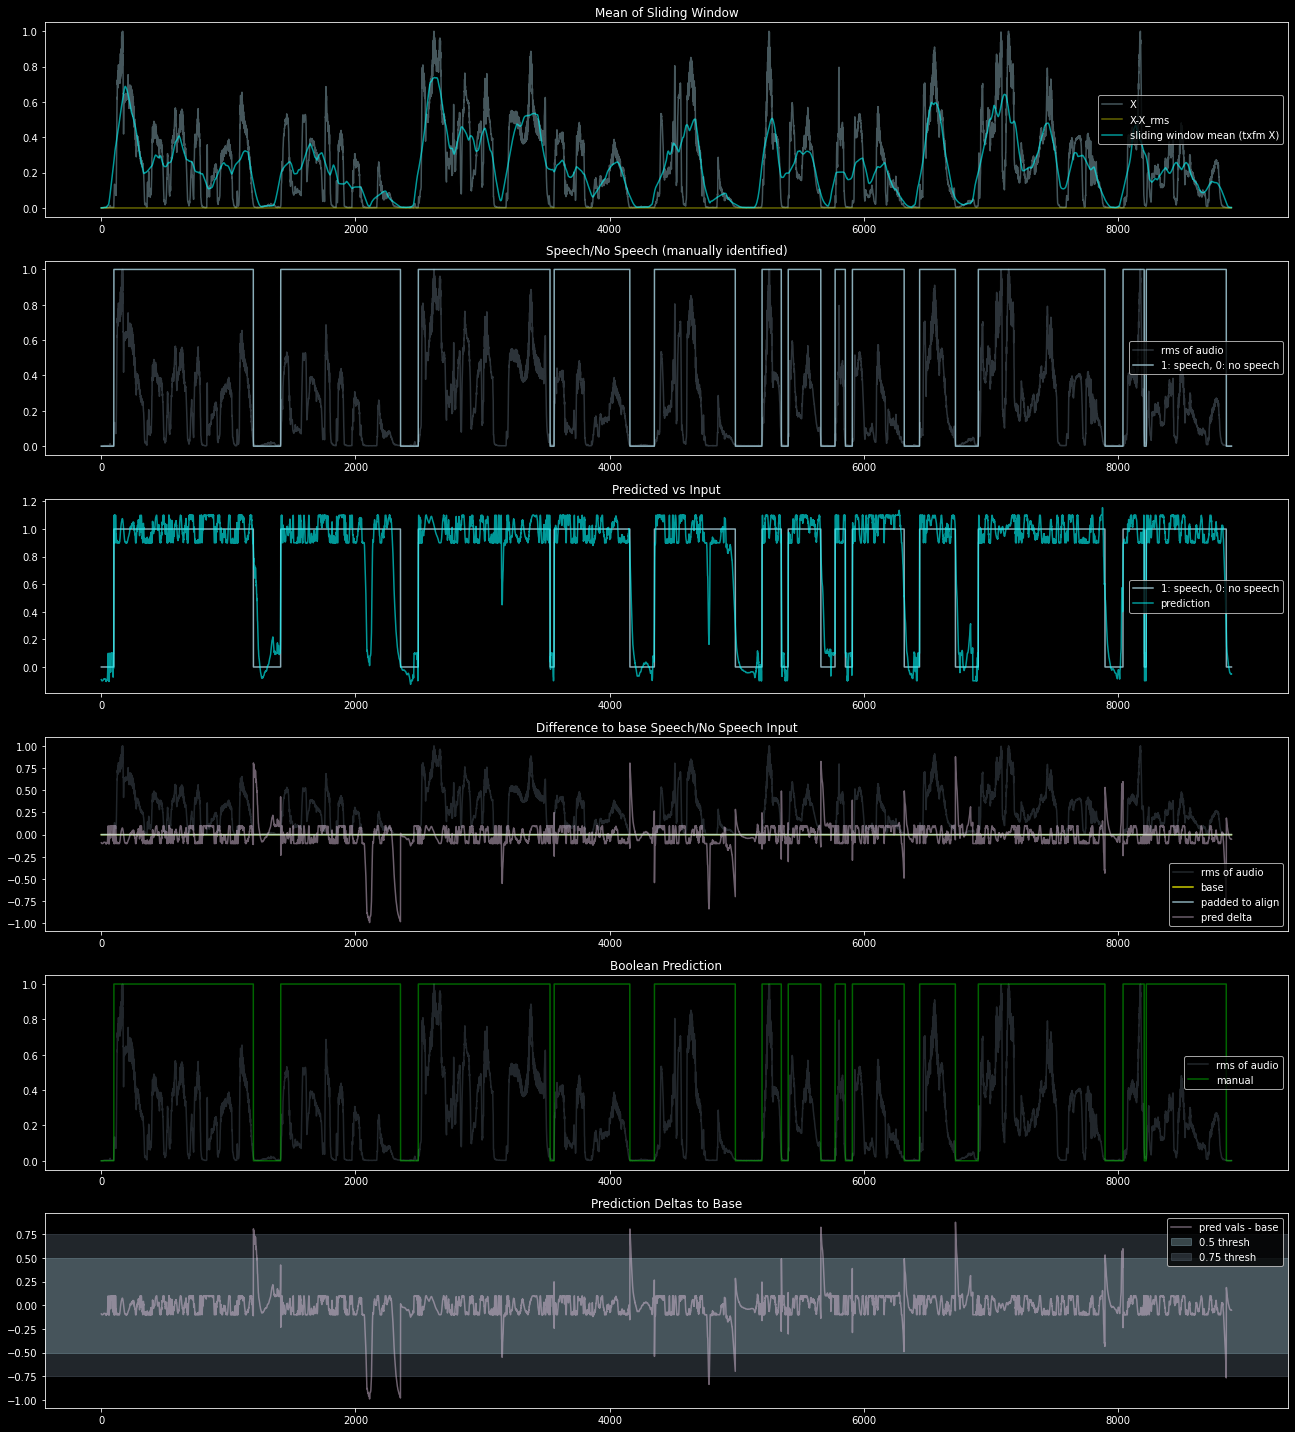

In [7]:
ModelPlot.plot(X_train, y_train, y_train_pred, sw_offset, x_rms, x_sw, sw_mean_offset)